# 2D Denoising Score Matching 實驗

##  實驗資料
常見的 2D 資料集：
- 雙峰高斯（GMM-2）：$x \sim \tfrac{1}{2}\mathcal{N}(\mu_1,\Sigma_1) + \tfrac{1}{2}\mathcal{N}(\mu_2,\Sigma_2)$  
- 兩圈同心圓（Two Circles）  
- 月牙形（Two Moons）  

---

## 實驗步驟
1. **Sample**：取一批 $x \in \mathbb{R}^2$  
2. **加噪**：$\tilde{x} = x + \sigma \epsilon,\ \epsilon \sim \mathcal{N}(0,I)$  
3. **模型**：$s_\theta(\tilde{x}, \sigma)$，輸入 $2$ 維 + 噪聲嵌入，輸出 $2$ 維向量  
4. **Training**：最小化 DSM loss  
5. **Visualization A**：在網格上畫出 $s_\theta(z,\sigma)$ 的向量場  
6. **Visualization B**：比較 $x$、$\tilde{x}$、與 $x^{(1)} = \tilde{x} + \eta s_\theta(\tilde{x},\sigma)$  
7. **Generation**：從純噪音逐步反推樣本分布  

---

## DSM Loss（單一噪聲）
給定 $x \sim p_{\text{data}}$、$\tilde{x} \sim \mathcal{N}(x, \sigma^2 I)$，  
模型應逼近：
$$
s_\theta(\tilde{x}, \sigma) \approx \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}|x) = -\frac{\tilde{x}-x}{\sigma^2}
$$

對應的loss function：
$$
\mathcal{L}_{\text{DSM}}(\theta) =
\mathbb{E}_{x,\tilde{x}}
\left[
\tfrac{1}{2}
\left\|
s_\theta(\tilde{x},\sigma)
+ \frac{\tilde{x}-x}{\sigma^2}
\right\|^2
\right]
$$

---

## DSM Loss（多噪聲版本）
若噪聲層級為 $\sigma_t$，則：
$$
\mathcal{L}_{\text{DSM}}(\theta) =
\mathbb{E}_{t,x,\epsilon}
\left[
\tfrac{1}{2} w(t)
\left\|
s_\theta(x + \sigma_t \epsilon, t)
+ \frac{\epsilon}{\sigma_t}
\right\|^2
\right]
$$
其中 $w(t)$ 可取 $1$、$\sigma_t^2$、或 $1/\sigma_t^2$。

---

## 實驗設定
- 資料量：每步 mini-batch $128 \sim 512$  
- 噪聲：單層 $\sigma \in [0.1, 0.2]$；或多層 $\sigma_t \in [1.0, 0.01]$  
- 模型：MLP（hidden $128 \sim 256$，SiLU/Swish，$2 \sim 4$ 層）  
- 學習率：$1\text{e-}3$  
- 評估：向量場、去噪前後散點圖、或生成分布對照  

---

## 重點
- DSM 學習訊號為：$-\frac{\tilde{x}-x}{\sigma^2}$ 或 $-\frac{\epsilon}{\sigma}$  
- 多尺度 DSM 是 diffusion model 的理論基礎  


## Experiment

In [1]:
import math, os, random, argparse
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons  #, make_circles

def set_seed(seed=0):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

DEVICE = torch.device("cpu")

In [2]:
def sample_gmm2(n=4096, means=None, covs=None, p=0.5, device=DEVICE):
    """
    2-component Gaussian Mixture in R^2
    """
    if means is None:
        means = [np.array([0.0, 0.0]), np.array([3.0, 3.0])]
    if covs is None:
        covs = [np.array([[1.0, 0.3],[0.3, 1.2]]),
                np.array([[0.6,-0.2],[-0.2, 0.8]])]

    z = np.random.rand(n) < p
    n1 = z.sum()
    n2 = n - n1
    x1 = np.random.multivariate_normal(means[0], covs[0], size=n1)
    x2 = np.random.multivariate_normal(means[1], covs[1], size=n2)
    X  = np.concatenate([x1, x2], axis=0).astype(np.float32)
    np.random.shuffle(X)
    return torch.tensor(X, device=device)

def sample_two_moons(n=4096, noise=0.06, device=DEVICE):
    X, _ = make_moons(n_samples=n, noise=noise)
    return torch.tensor(X, dtype=torch.float32, device=device)

#def sample_two_circles(n=4096, noise=0.06, factor=0.5, device=DEVICE):
#    X, _ = make_circles(n_samples=n, noise=noise, factor=factor)
#    return torch.tensor(X, dtype=torch.float32, device=device)

def get_dataset(name, n, device=DEVICE):
    name = name.lower()
    if name == "gmm2":
        return sample_gmm2(n=n, device=device)
    elif name == "moons":
        return sample_two_moons(n=n, device=device)
#    elif name == "circles":
#        return sample_two_circles(n=n, device=device)
    else:
        raise ValueError(f"Unknown dataset: {name}")

In [3]:
# 生成noise
def geometric_sigma_schedule(T=8, sigma_min=0.01, sigma_max=1.0):
    """
    Returns list [sigma_1, ..., sigma_T] geometric from max -> min
    """
    sigmas = np.geomspace(sigma_max, sigma_min, T).astype(np.float32)
    return torch.tensor(sigmas)

# Time embedding
class FourierTimeEmbedding(nn.Module):
    """
    Simple Fourier features for noise level index t (or continuous)
    """
    def __init__(self, dim=64, max_freq=10.0):
        super().__init__()
        self.dim = dim
        self.max_freq = max_freq
        # We will map a scalar (e.g., log sigma) to 2*dim features via sin/cos

    def forward(self, s):  # s: (B,) any scalar (e.g., log(sigma))
        # shape -> (B,1)
        s = s.view(-1, 1)
        # frequencies
        B = s.shape[0]
        k = torch.linspace(1.0, self.max_freq, self.dim, device=s.device).view(1, -1)
        angles = s * k  # (B,dim)
        emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)  # (B, 2*dim)
        return emb

In [4]:
class ScoreMLP(nn.Module):
    def __init__(self, hidden=256, time_dim=64, num_layers=3):
        super().__init__()
        self.t_emb = FourierTimeEmbedding(dim=time_dim)
        in_dim = 2 + 2*time_dim

        layers = []
        h = hidden
        layers += [nn.Linear(in_dim, h), nn.SiLU()]
        for _ in range(num_layers-1):
            layers += [nn.Linear(h, h), nn.SiLU()]
        layers += [nn.Linear(h, 2)]
        self.net = nn.Sequential(*layers)

    def forward(self, x, log_sigma):
        # x: (B,2), log_sigma: (B,)
        te = self.t_emb(log_sigma)  # (B, 2*time_dim)
        z  = torch.cat([x, te], dim=-1)
        return self.net(z)


## DSM Loss

In [5]:
def dsm_loss_multi_sigma(model, x, sigmas, w_mode="none"):
    B = x.shape[0]
    T = len(sigmas)
    t_idx = torch.randint(0, T, (B,), device=x.device)  # 0..T-1
    sigma_t = sigmas[t_idx]  # (B,)
    eps = torch.randn_like(x)
    x_tilde = x + sigma_t.view(-1,1) * eps
    target = - eps / sigma_t.view(-1,1)

    # weights
    if w_mode == "none":
        w = torch.ones(B, device=x.device)
    elif w_mode == "sigma2":
        w = sigma_t**2
    elif w_mode == "inv_sigma2":
        w = 1.0 / (sigma_t**2 + 1e-12)

    log_sigma = torch.log(sigma_t + 1e-12)
    score_hat = model(x_tilde, log_sigma)  # (B,2)

    loss = 0.5 * ((score_hat - target)**2).sum(dim=-1)  # (B,)
    loss = (w * loss).mean()
    return loss

class WeightEMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {k: v.clone().detach() for k, v in model.state_dict().items()}

    @torch.no_grad()
    def update(self, model):
        for k, v in model.state_dict().items():
            assert k in self.shadow
            self.shadow[k].mul_(self.decay).add_(v, alpha=1.0 - self.decay)

    @torch.no_grad()
    def copy_to(self, model):
        model.load_state_dict(self.shadow, strict=True)

In [7]:
# Visualization
# ----------------
@torch.no_grad()
def plot_vector_field(model, sigma, xlim=(-3,6), ylim=(-3,6), N=25, fname="quiver.png"):
    """
    On a grid, draw s_theta(z, sigma)
    """
    xs = torch.linspace(xlim[0], xlim[1], N, device=DEVICE)
    ys = torch.linspace(ylim[0], ylim[1], N, device=DEVICE)
    Xg, Yg = torch.meshgrid(xs, ys, indexing="xy")
    grid = torch.stack([Xg.reshape(-1), Yg.reshape(-1)], dim=-1)  # (N*N,2)
    log_sigma = torch.full((grid.shape[0],), math.log(sigma), device=DEVICE)
    V = model(grid, log_sigma).cpu().numpy()
    G = grid.cpu().numpy()

    plt.figure(figsize=(6,5))
    plt.quiver(G[:,0], G[:,1], V[:,0], V[:,1], angles='xy', scale_units='xy', scale=30)
    plt.title(f"Score Field (sigma={sigma:.3g})")
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.tight_layout()
    plt.savefig(fname, dpi=160)
    plt.close()

@torch.no_grad()
def plot_denoise_step(model, x, sigma, eta=0.1, n_show=1500, fname="denoise_scatter.png"):
    """
    Compare original x, noisy x~, and one-step denoised x^(1) = x~ + eta * s_theta(x~, sigma)
    """
    n = min(n_show, x.shape[0])
    idx = torch.randperm(x.shape[0], device=x.device)[:n]
    x_ = x[idx]
    eps = torch.randn_like(x_)
    x_tilde = x_ + sigma * eps
    log_sigma = torch.full((n,), math.log(sigma), device=x.device)
    score_hat = model(x_tilde, log_sigma)
    x1 = x_tilde + eta * score_hat

    X = x_.cpu().numpy()
    XT = x_tilde.cpu().numpy()
    X1 = x1.cpu().numpy()

    plt.figure(figsize=(6,5))
    plt.scatter(X[:,0],  X[:,1],  s=8, alpha=0.6, label="clean x")
    plt.scatter(XT[:,0], XT[:,1], s=8, alpha=0.6, label="noisy x~")
    plt.scatter(X1[:,0], X1[:,1], s=8, alpha=0.6, label="denoised x^(1)")
    plt.legend()
    plt.title(f"One-step Denoising (sigma={sigma:.3g}, eta={eta})")
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.tight_layout()
    plt.savefig(fname, dpi=160)
    plt.close()

# -----------
# Training
# -----------
def train(model, data, sigmas, steps=5000, batch_size=256, lr=1e-3, ema_decay=0.999, w_mode="none", log_every=200):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0)
    ema = WeightEMA(model, decay=ema_decay)
    n = data.shape[0]
    losses = []

    for step in range(1, steps+1):
        idx = torch.randint(0, n, (batch_size,), device=data.device)
        x_b = data[idx]
        loss = dsm_loss_multi_sigma(model, x_b, sigmas.to(data.device), w_mode=w_mode)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        ema.update(model)

        losses.append(loss.item())
        if step % log_every == 0:
            print(f"[{step:5d}/{steps}] loss={np.mean(losses[-log_every:]):.6f}")

    # swap to EMA weights for eval
    ema.copy_to(model)
    return losses

# -----------
# Main
# -----------
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--data", type=str, default="gmm2", choices=["gmm2","moons","circles"])
    parser.add_argument("--n", type=int, default=8192, help="dataset size")
    parser.add_argument("--steps", type=int, default=4000)
    parser.add_argument("--batch", type=int, default=256)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--w_mode", type=str, default="none", choices=["none","sigma2","inv_sigma2"])
    parser.add_argument("--T", type=int, default=8, help="# noise levels")
    parser.add_argument("--sigma_min", type=float, default=0.02)
    parser.add_argument("--sigma_max", type=float, default=0.8)
    parser.add_argument("--hidden", type=int, default=256)
    parser.add_argument("--layers", type=int, default=3)
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--outdir", type=str, default="out_dsm2d")
    parser.add_argument("--viz_sigma", type=float, default=0.1, help="sigma used for quiver & denoise plots")
    parser.add_argument("--eta", type=float, default=0.15, help="one-step denoise step size")
    args = parser.parse_args([])

    os.makedirs(args.outdir, exist_ok=True)
    set_seed(args.seed)

    # data
    x = get_dataset(args.data, n=args.n, device=DEVICE)

    # sigmas
    sigmas = geometric_sigma_schedule(T=args.T, sigma_min=args.sigma_min, sigma_max=args.sigma_max).to(DEVICE)

    # model
    model = ScoreMLP(hidden=args.hidden, time_dim=64, num_layers=args.layers).to(DEVICE)

    print(f"Device: {DEVICE} | Data: {args.data} | N={args.n}")
    print(f"Sigmas: {sigmas.cpu().numpy()}")
    print(f"Model: hidden={args.hidden}, layers={args.layers}")

    # train
    train(model, x, sigmas, steps=args.steps, batch_size=args.batch, lr=args.lr, w_mode=args.w_mode)

    # visualize score field and one-step denoise
    qfile = os.path.join(args.outdir, "quiver.png")
    dfile = os.path.join(args.outdir, "denoise_scatter.png")
    plot_vector_field(model, sigma=args.viz_sigma, fname=qfile)
    plot_denoise_step(model, x, sigma=args.viz_sigma, eta=args.eta, fname=dfile)

    print(f"Saved: {qfile}")
    print(f"Saved: {dfile}")
    print("Done.")

if __name__ == "__main__":
    main()

Device: cpu | Data: gmm2 | N=8192
Sigmas: [0.8        0.47230688 0.27884224 0.16462389 0.09719124 0.05738012
 0.03387628 0.02      ]
Model: hidden=256, layers=3
[  200/4000] loss=475.251406
[  400/4000] loss=485.155596
[  600/4000] loss=484.915249
[  800/4000] loss=484.945996
[ 1000/4000] loss=473.500053
[ 1200/4000] loss=476.338119
[ 1400/4000] loss=486.520213
[ 1600/4000] loss=478.390259
[ 1800/4000] loss=484.318191
[ 2000/4000] loss=471.199506
[ 2200/4000] loss=473.568166
[ 2400/4000] loss=479.574167
[ 2600/4000] loss=480.486772
[ 2800/4000] loss=479.241817
[ 3000/4000] loss=473.593054
[ 3200/4000] loss=493.855552
[ 3400/4000] loss=474.849573
[ 3600/4000] loss=477.049945
[ 3800/4000] loss=483.214860
[ 4000/4000] loss=483.349276
Saved: out_dsm2d\quiver.png
Saved: out_dsm2d\denoise_scatter.png
Done.


生成出來的圖：  


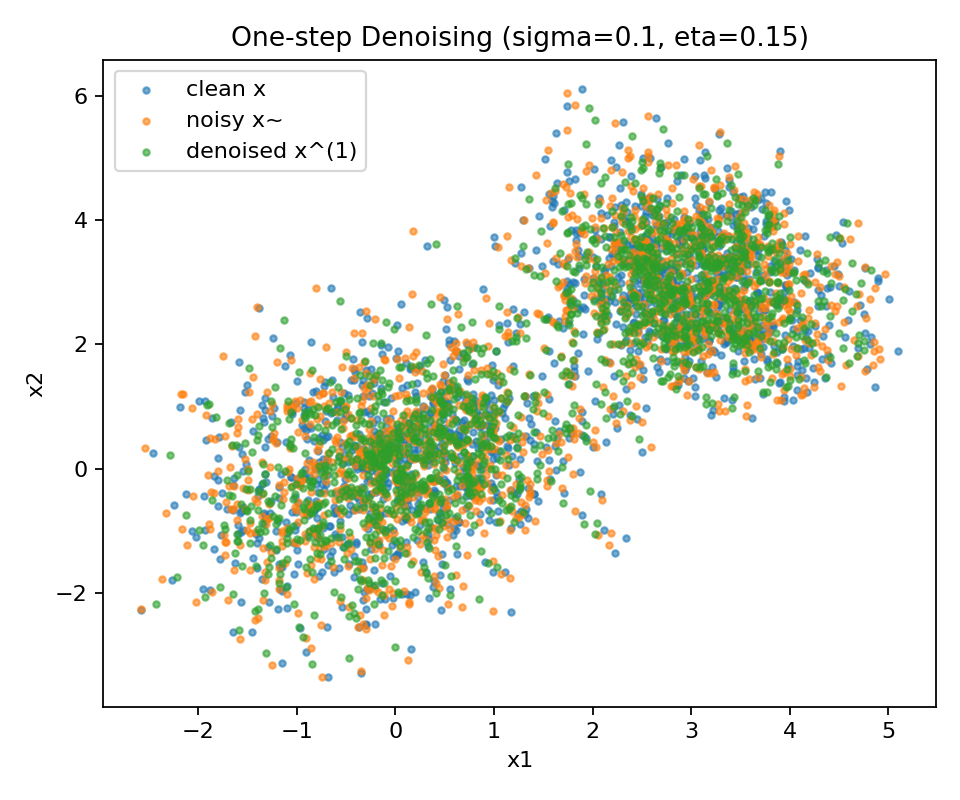
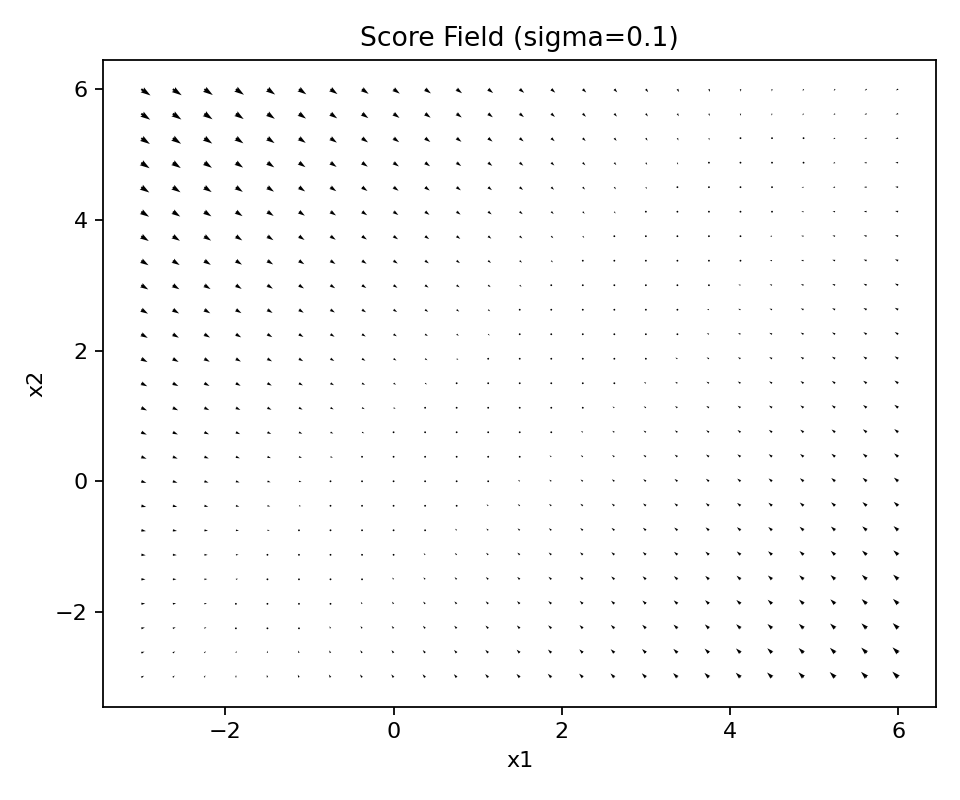



### 心得
這邊chatgpt 似乎把所有東西都包裝成main()了  
看可不可以改成正常的版本  
不過先跑跑看就是了